
# Hackathon - Binary Classification - Solutions

In this notebook you will find the instructor's solution to the hackathon. This is one approach of many possible.
The main goal is to provide you a baseline that you can modify/expand upon and show you how to take advantage of sklearn's pipeline to simplify your workflow.

### Import the necessary libraries

In [1]:
# Import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# Sklearn libraries
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,classification_report,auc
from sklearn.base import BaseEstimator, TransformerMixin # to create classes

# Category encoders
from category_encoders import OneHotEncoder, TargetEncoder

#### Import the dataset

In [2]:
# You might have to change this path or the location of this file
data = pd.read_csv('data/train.csv').set_index("ID")

In [3]:
data.head()

,DATE_DEPARTURE_UTC,DATE_ARRIVAL_UTC,DATE_DEPARTURE_LCL,DATE_ARRIVAL_LCL,ORIGIN,ORIGIN_AIRPORT_ID,DEST,DEST_AIRPORT_ID,TAIL_NUM,OP_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER_FL_NUM,DISTANCE,CANCELLED,DEP_DEL15,ARR_DEL15
ID,,,,,,,,,,,,,,,,
345355,2020-01-18 22:10:00,2020-01-18 23:59:00,2020-01-18 15:10:00,2020-01-18 15:59:00,SLC,14869,SNA,14908,N128DU,DL,19790,1056,588.0,0,0.0,0
323447,2020-01-17 21:47:00,2020-01-18 04:10:00,2020-01-17 16:47:00,2020-01-17 20:10:00,BOS,10721,SEA,14747,N486AS,AS,19930,15,2496.0,0,NaN,0
242237,2020-01-13 13:26:00,2020-01-13 14:26:00,2020-01-13 07:26:00,2020-01-13 08:26:00,DAL,11259,HOU,12191,N901WN,WN,19393,3,239.0,0,NaN,0
271408,2020-01-15 02:45:00,2020-01-15 03:37:00,2020-01-14 20:45:00,2020-01-14 21:37:00,STL,15016,DSM,11423,N778SW,WN,19393,1588,259.0,0,0.0,0
282447,2020-01-15 23:22:00,2020-01-16 00:49:00,2020-01-15 18:22:00,2020-01-15 19:49:00,CLT,11057,CHS,10994,N579NN,OH,20397,5207,168.0,0,NaN,1


### EDA (Exploratory Dataset Analysis)

Let's start by checking the number of unique values per column.

In [4]:
data.nunique()

DATE_DEPARTURE_UTC       29661
DATE_ARRIVAL_UTC         30137
DATE_DEPARTURE_LCL       26687
DATE_ARRIVAL_LCL         28477
ORIGIN                     351
ORIGIN_AIRPORT_ID          351
DEST                       350
DEST_AIRPORT_ID            350
TAIL_NUM                  5376
OP_CARRIER                  17
OP_CARRIER_AIRLINE_ID       17
OP_CARRIER_FL_NUM         6715
DISTANCE                  1468
CANCELLED                    1
DEP_DEL15                    2
ARR_DEL15                    2
dtype: int64

We can see some of the columns are not adding any value to the model. Let's drop them.

In [5]:
cols_irrelevant=["ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID", "OP_CARRIER_AIRLINE_ID", "CANCELLED"]

In [6]:
data = data.drop(columns=cols_irrelevant)

Let's check the data types we are dealing with.

In [7]:
data.dtypes

DATE_DEPARTURE_UTC     object
DATE_ARRIVAL_UTC       object
DATE_DEPARTURE_LCL     object
DATE_ARRIVAL_LCL       object
ORIGIN                 object
DEST                   object
TAIL_NUM               object
OP_CARRIER             object
OP_CARRIER_FL_NUM       int64
DISTANCE              float64
DEP_DEL15             float64
ARR_DEL15               int64
dtype: object

We can see dates are in the incorrect format. We'll have to convert them.

In [8]:
date_cols_to_convert = ["DATE_DEPARTURE_UTC", "DATE_ARRIVAL_UTC", "DATE_DEPARTURE_LCL", "DATE_ARRIVAL_LCL"]
data[date_cols_to_convert] = data[date_cols_to_convert].apply(pd.to_datetime, format="%Y/%m/%d %H:%M:%S")

In [9]:
data.dtypes

DATE_DEPARTURE_UTC    datetime64[ns]
DATE_ARRIVAL_UTC      datetime64[ns]
DATE_DEPARTURE_LCL    datetime64[ns]
DATE_ARRIVAL_LCL      datetime64[ns]
ORIGIN                        object
DEST                          object
TAIL_NUM                      object
OP_CARRIER                    object
OP_CARRIER_FL_NUM              int64
DISTANCE                     float64
DEP_DEL15                    float64
ARR_DEL15                      int64
dtype: object

Much better now!

Let's check if we have any missing values to worry about.

In [10]:
data.isna().sum()

DATE_DEPARTURE_UTC         0
DATE_ARRIVAL_UTC           0
DATE_DEPARTURE_LCL         0
DATE_ARRIVAL_LCL           0
ORIGIN                     0
DEST                       0
TAIL_NUM                   0
OP_CARRIER                 0
OP_CARRIER_FL_NUM          0
DISTANCE               17618
DEP_DEL15             146820
ARR_DEL15                  0
dtype: int64

Hmm, two features have missing values.

In the case of the `DISTANCE` column you may have noticed some of the missing values can be filled with information from other rows.

In [11]:
data[["ORIGIN", "DEST", "DISTANCE"]].sort_values(by=["ORIGIN"]).head()

,ORIGIN,DEST,DISTANCE
ID,,,
211515,ABE,PIE,970.0
275169,ABE,SFB,882.0
140902,ABE,ATL,NaN
14329,ABE,PGD,1018.0
281846,ABE,ATL,692.0


In [12]:
# Start by isolating the information that is available to you regarding the variable distance
data_distance = data[["ORIGIN","DEST","DISTANCE"]].dropna().copy()
# Create a dict that matches (Origin, destination) tuples to distances
distance_dict = data_distance.set_index(["ORIGIN","DEST"])["DISTANCE"].to_dict()
# Replace any missing value with the information contained in the dict 
data["DISTANCE"] = data.apply(lambda row: distance_dict[(row["ORIGIN"], row["DEST"])]
                        if np.isnan(row["DISTANCE"]) and (row["ORIGIN"], row["DEST"]) in distance_dict.keys()
                        else row["DISTANCE"], axis=1)

In [13]:
#distance_dict

Result:

In [14]:
data.isna().sum()

DATE_DEPARTURE_UTC         0
DATE_ARRIVAL_UTC           0
DATE_DEPARTURE_LCL         0
DATE_ARRIVAL_LCL           0
ORIGIN                     0
DEST                       0
TAIL_NUM                   0
OP_CARRIER                 0
OP_CARRIER_FL_NUM          0
DISTANCE                   7
DEP_DEL15             146820
ARR_DEL15                  0
dtype: int64

We are able to get rid of most of the missing values in this feature.

Let's check the correlation.

In [15]:
data.corr()[data.corr().abs()>0.7]

,OP_CARRIER_FL_NUM,DISTANCE,DEP_DEL15,ARR_DEL15
OP_CARRIER_FL_NUM,1.0,NaN,NaN,NaN
DISTANCE,NaN,1.0,NaN,NaN
DEP_DEL15,NaN,NaN,1.000000,0.713799
ARR_DEL15,NaN,NaN,0.713799,1.000000


The feature `DEP_DEL15` is highly correlated with our target variable. This feature is likely to be very useful.

Let's also check if are dealing with an imbalanced dataset.

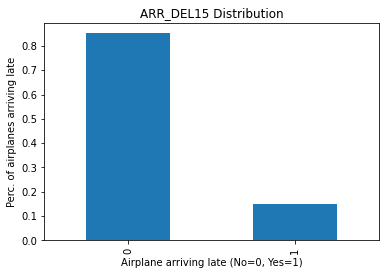

In [16]:
# Checking if the dataset is imbalanced 
data["ARR_DEL15"].value_counts(normalize=True).plot(kind="bar")
plt.title('ARR_DEL15 Distribution')
plt.xlabel("Airplane arriving late (No=0, Yes=1)")
plt.ylabel("Perc. of airplanes arriving late");

Note: You can also use [pandas-profiling](https://github.com/pandas-profiling/pandas-profiling)!

In [17]:
#from pandas_profiling import ProfileReport
#report = ProfileReport(data)
#report

### Putting all these steps together

Let's put the steps above into classes so they can be integrated our pipeline.

In [18]:
class DistanceFixNA(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X=None, y=None, **fit_params):
        data_distance = X[["ORIGIN","DEST","DISTANCE"]].dropna().copy()
        self.distance_mapping = data_distance.set_index(["ORIGIN","DEST"])["DISTANCE"].to_dict()
        return self
    def transform(self, data):
        X = data.copy()
        X["DISTANCE"] = X.apply(lambda row: self.distance_mapping[(row["ORIGIN"], row["DEST"])]
                                if np.isnan(row["DISTANCE"]) and (row["ORIGIN"], row["DEST"]) in self.distance_mapping.keys()
                                else row["DISTANCE"], axis=1)
        X["DISTANCE"] = X["DISTANCE"].fillna(X["DISTANCE"].median())
        return X

In [19]:
class DroppingColumns(BaseEstimator, TransformerMixin):
    def __init__(self, cols=[]):
        self.cols = cols
    def fit(self, X=None, y=None, **fit_params):
        return self
    def transform(self, data):
        X = data.copy()
        X = X.drop(self.cols,axis=1)
        return X

### Feature Engineering

Create new columns with the **hour** and **day of the week** of each flight

In [20]:
class CreateTimeFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, cols=[]):
        self.cols = cols
    def fit(self, X=None, y=None, **fit_params):
        return self
    def transform(self, data):
        X = data.copy()
        for col in self.cols:
            X["HOUR" + col.replace("DATE","")] = X[col].dt.hour
            X["WEEK_DAY" + col.replace("DATE","")] = X[col].dt.dayofweek
        return X

Produce a new feature **speed** from the `DISTANCE`, `DATE_ARRIVAL_UTC`, and `DATE_DEPARTURE_UTC` columns

In [21]:
class CalcSpeed(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X=None, y=None, **fit_params):
        return self
    def transform(self, data):
        X = data.copy()
        X["SPEED"] = data["DISTANCE"] / (X["DATE_ARRIVAL_UTC"] - X["DATE_DEPARTURE_UTC"]).dt.total_seconds()
        return X

### Creating the Model 

Import the dataset again (let's do the same transformations using the pipeline)

In [22]:
data = pd.read_csv('data/train.csv').set_index("ID")
# Converting date columns to datetime
data[date_cols_to_convert] = data[date_cols_to_convert].apply(pd.to_datetime, format="%Y/%m/%d %H:%M:%S")

Preparing the dataset for the split (don't forget to sort)

In [23]:
data = data.sort_values(by="DATE_DEPARTURE_LCL")
X = data.drop(columns=['ARR_DEL15'])
y = data['ARR_DEL15']

Splitting the dataset between test and train

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=False) # be careful here. By default the dataset is shuffled

Creating the pipeline

In [25]:
time_features_cols = ['DATE_DEPARTURE_LCL','DATE_ARRIVAL_LCL']
# This is just a list with the name of the new time features we created in the step "create_time_features"
new_time_variables = [ft+col.replace("DATE","") for col in time_features_cols for ft in ["WEEK_DAY", "HOUR"]]
cols_to_drop = ['OP_CARRIER', 'OP_CARRIER_FL_NUM', 'TAIL_NUM', 'DATE_DEPARTURE_UTC','DATE_ARRIVAL_UTC',
                'DATE_DEPARTURE_LCL','DATE_ARRIVAL_LCL']

pipeline = Pipeline([("distance_fix", DistanceFixNA()),
                     ("create_time_features", CreateTimeFeatures(cols=time_features_cols)),
                     ('onehot_encoding', OneHotEncoder(cols=new_time_variables)),
                     ('departure_encoding', OneHotEncoder(cols=["DEP_DEL15"], handle_missing="indicator")),
                     ('target_encoding',TargetEncoder(cols=['DEST',"ORIGIN"], min_samples_leaf=30)),
                     ('speed', CalcSpeed()),
                     ("drop_columns", DroppingColumns(cols=cols_irrelevant + cols_to_drop)),
                     ('model', RandomForestClassifier(random_state=42))])

Train the model and generate the predictions

In [26]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('distance_fix', DistanceFixNA()),
                ('create_time_features',
                 CreateTimeFeatures(cols=['DATE_DEPARTURE_LCL',
                                          'DATE_ARRIVAL_LCL'])),
                ('onehot_encoding',
                 OneHotEncoder(cols=['WEEK_DAY_DEPARTURE_LCL',
                                     'HOUR_DEPARTURE_LCL',
                                     'WEEK_DAY_ARRIVAL_LCL',
                                     'HOUR_ARRIVAL_LCL'])),
                ('departure_encoding',
                 OneHotEncoder(cols=['DEP_DEL15'], handle_missing='indicato...
                 TargetEncoder(cols=['DEST', 'ORIGIN'], min_samples_leaf=30)),
                ('speed', CalcSpeed()),
                ('drop_columns',
                 DroppingColumns(cols=['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID',
                                       'OP_CARRIER_AIRLINE_ID', 'CANCELLED',
                                       'OP_CARRIER', 'OP_CARRIER_FL_NUM',


In [27]:
y_scores = pipeline.predict_proba(X_test)[:,1]

Score: 0.92


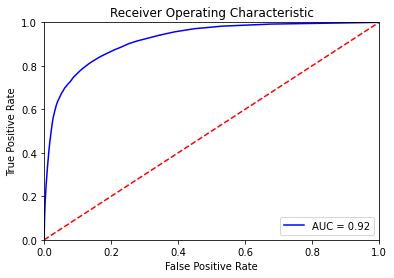

In [28]:
fpr, tpr, threshold = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
print("Score: "+ str(round(roc_auc,3)))
plt.show()

#### Check final score using the test set

Load the test set

In [29]:
test = pd.read_csv('data/test.csv').set_index("ID")
# Don't forget to convert dates to timestamp again
test[date_cols_to_convert] = test[date_cols_to_convert].apply(pd.to_datetime, format="%Y/%m/%d %H:%M:%S")

Use the pipeline to get predictions (very simple!)

In [30]:
y_scores_final = pipeline.predict_proba(test)[:,1]

Prepare the submissions file

In [31]:
submission = pd.Series(y_scores_final,index=test.index, name='ARR_DEL15')
submission.to_csv("submission.csv")

This should get you a 0.915!